In [142]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

# Define the city or place you want to retrieve the graph for

def get_graph(place_name):
    # Retrieve the street network graph
    graph = ox.graph_from_place(place_name, network_type='drive')
    
    # Plot the graph
    fig, ax = ox.plot_graph(graph, figsize=(10, 10), node_size=0, edge_linewidth=0.5)
    
    # Show the plot
    plt.show()
    return graph

In [143]:
import heapq

def dijkstra(graph, start):
    # Priority queue to store (distance, node) pairs
    queue = [(0, start)]
    # Dictionary to store the shortest distance to each node
    distances = {node: float('inf') for node in graph.nodes}
    distances[start] = 0

    while queue:
        current_distance, current_node = heapq.heappop(queue)

        # Explore neighbors
        for neighbor, edge_data in graph[current_node].items():
            distance = current_distance + edge_data[0].get('length', 1)  # Use edge length as weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                heapq.heappush(queue, (distance, neighbor))

    return distances

In [144]:
# Define the origin point (latitude, longitude)
# origin_point = (5, 11.5882)

def find_closest_hospital(graph, hospital_nodes, origin_node, hospitals):
    
    # Compute shortest distances from the origin to all nodes
    shortest_distances = dijkstra(graph, origin_node)
    
    # Find the closest hospital
    closest_hospital = None
    min_distance = float('inf')
    
    for i, hospital_node in enumerate(hospital_nodes):
        distance = shortest_distances[hospital_node]
        if distance < min_distance:
            min_distance = distance
            closest_hospital = hospitals.iloc[i]
    
    # Print the closest hospital
    print("Closest Hospital:")
    print(closest_hospital[['name', 'geometry']])
    print(f"Distance: {min_distance:.2f} meters")
    return closest_hospital, min_distance


In [145]:
import matplotlib.pyplot as plt

def show_map_path(graph, closest_hospital, origin_point, origin_node, min_distance):
    # Get the centroid or coordinates of the closest hospital
    if closest_hospital.geometry.geom_type == 'Point':
        hospital_coords = (closest_hospital.geometry.y, closest_hospital.geometry.x)
    else:
        hospital_coords = (closest_hospital.geometry.centroid.y, closest_hospital.geometry.centroid.x)
    
    # Find the nearest node to the closest hospital
    closest_hospital_node = ox.distance.nearest_nodes(graph, hospital_coords[1], hospital_coords[0])
    
    # Get the shortest path to the closest hospital
    shortest_path = nx.shortest_path(graph, origin_node, closest_hospital_node, weight='length')
    
    # Plot the graph and the shortest path
    fig, ax = ox.plot_graph_route(graph, shortest_path, route_linewidth=6, node_size=0, figsize=(10, 10), show=False, close=False)
    
    # Plot the origin and closest hospital
    ax.scatter(origin_point[1], origin_point[0], c='blue', s=100, label='Origin', zorder=5)
    ax.scatter(hospital_coords[1], hospital_coords[0], c='red', s=100, label='Closest Hospital', zorder=5)
    
    # Add legend and title
    plt.legend()
    plt.title(f"Closest Hospital: {closest_hospital['name']} ({min_distance:.2f} meters)", fontsize=15)
    
    # Show the plot
    plt.show()

In [146]:
def retrieve_city_graph(city):
    place_name = f"{city}, DE"
    graph = get_graph(place_name)
    
    # Retrieve all hospitals within the city boundaries
    hospitals = ox.features_from_place(place_name, tags={'amenity': 'hospital'})
    
    # nodes, edges = ox.graph_to_gdfs(graph)
    # Extract hospital geometries (latitude, longitude)
    # hospital_points = hospitals.geometry.apply(lambda geom: (geom.y, geom.x))
    # Extract centroid or coordinates for each hospital
    hospital_points = hospitals.geometry.apply(
        lambda geom: (geom.centroid.y, geom.centroid.x) if geom.geom_type != 'Point' else (geom.y, geom.x))
    # Find the nearest graph node for each hospital
    hospital_nodes = [ox.distance.nearest_nodes(graph, point[1], point[0]) for point in hospital_points]

    return graph, hospital_nodes, hospitals

In [147]:
global_cities_cache = {}

Closest Hospital:
name                                   St. Hedwig-Krankenhaus
geometry    POLYGON ((13.3952746 52.5252712, 13.3952591 52...
Name: (way, 24054786), dtype: object
Distance: 1279.68 meters


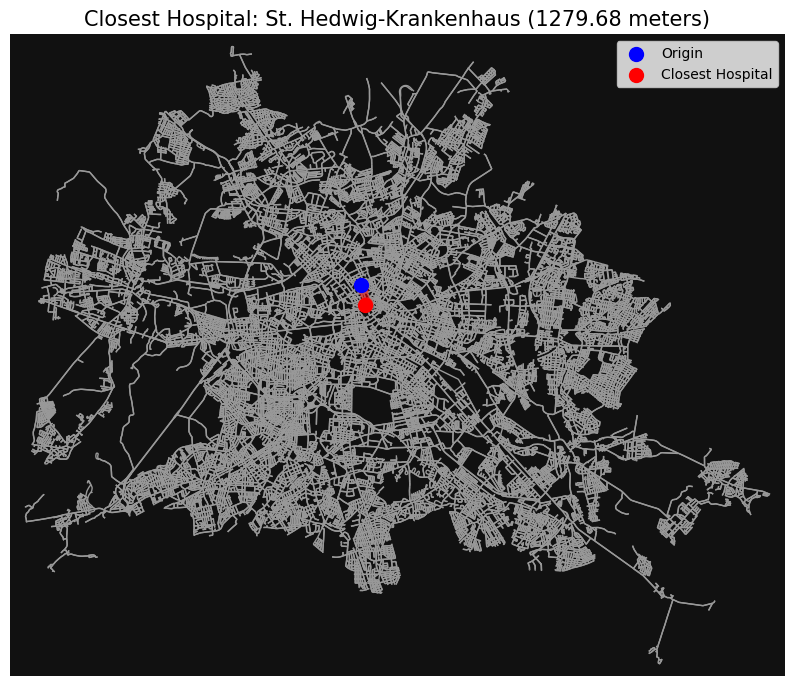

Closest Hospital:
name                              DRK Kliniken Berlin Westend
geometry    POLYGON ((13.2760982 52.5189603, 13.2778328 52...
Name: (way, 53038853), dtype: object
Distance: 1331.25 meters


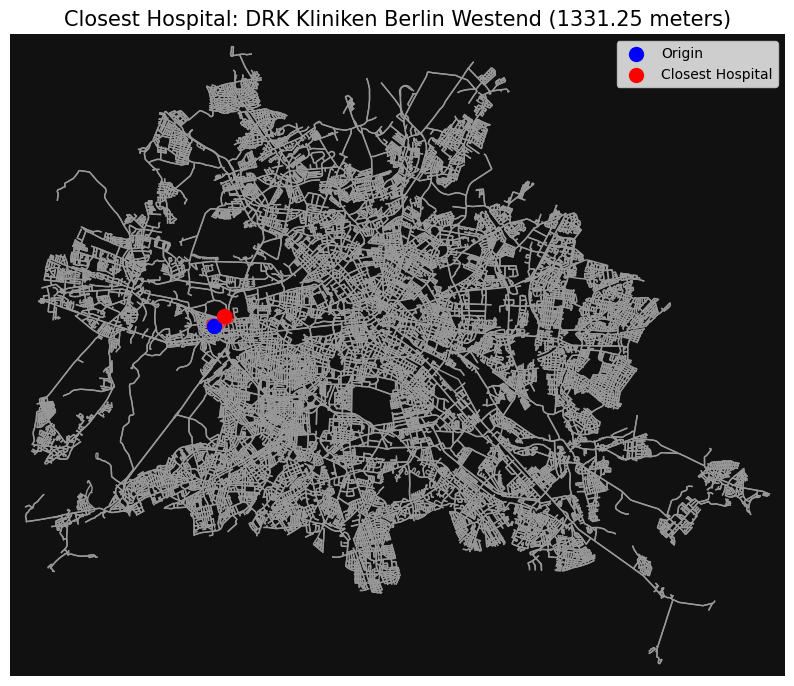

Closest Hospital:
name                    Krankenhaus St. Marienstift Magdeburg
geometry    POLYGON ((11.5992696 52.1380599, 11.5993933 52...
Name: (way, 22975608), dtype: object
Distance: 899.19 meters


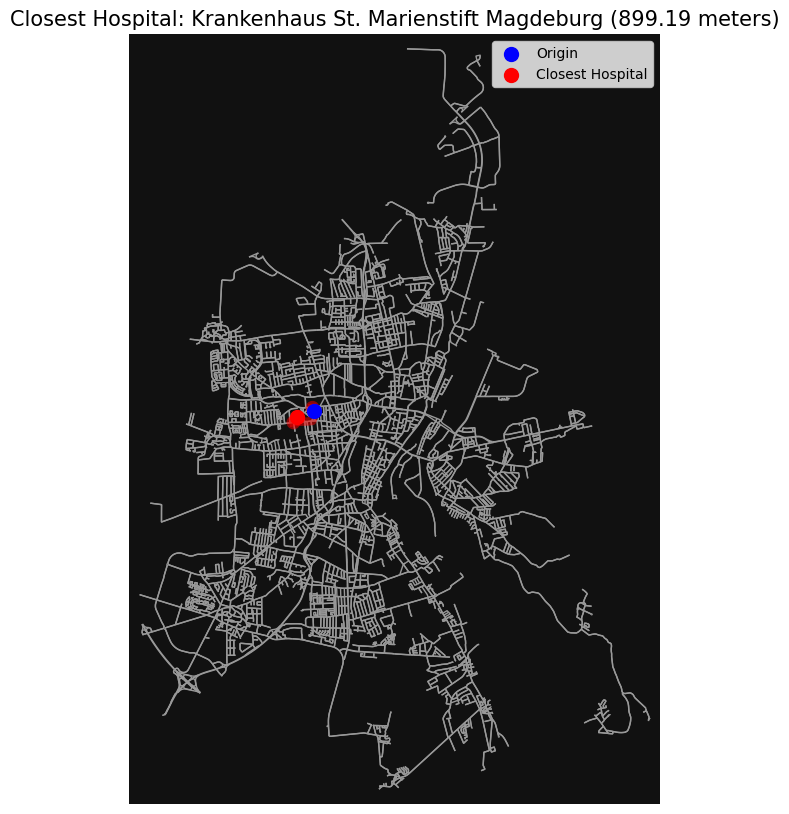

Closest Hospital:
name                           Universitätsklinikum Magdeburg
geometry    POLYGON ((11.6122638 52.1049781, 11.6125109 52...
Name: (way, 516713300), dtype: object
Distance: 1431.70 meters


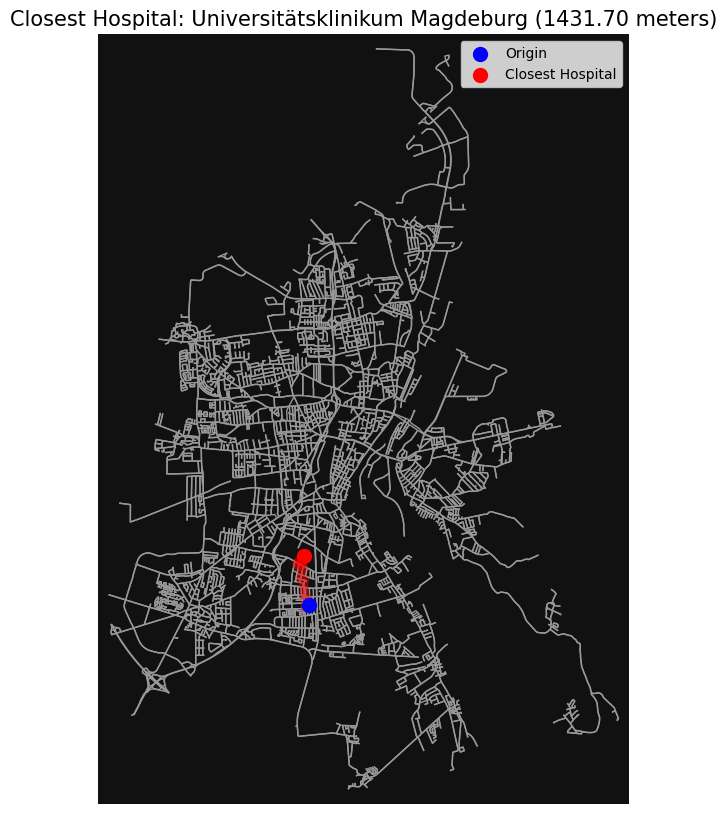

Closest Hospital:
name                                        Median Klinik NRZ
geometry    POLYGON ((11.6375096 52.0864957, 11.6375803 52...
Name: (relation, 89329), dtype: object
Distance: 1089.22 meters


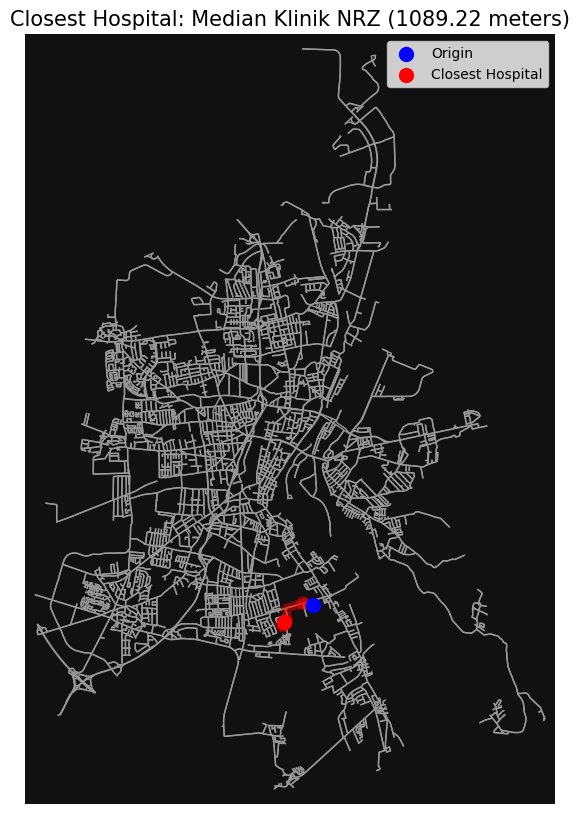

In [152]:
def main(city, point):
    if city in global_cities_cache:
        graph, hospital_nodes, hospitals = global_cities_cache[city]
    else: 
        graph, hospital_nodes, hospitals = retrieve_city_graph(city)
        global_cities_cache[city] = [graph, hospital_nodes, hospitals]
        
    origin_node = ox.distance.nearest_nodes(graph, point[1], point[0])
    closest_hospital, min_distance = find_closest_hospital(graph, hospital_nodes, origin_node, hospitals)

    show_map_path(graph, closest_hospital, point, origin_node, min_distance)
    
points = [ ("Berlin", ( 52.53628, 13.39388)), ("Berlin", (52.51546, 13.26861)), ("Magdeburg", (52.1383, 11.6071)), ("Magdeburg", (52.09048, 11.61770)), ("Magdeburg", (52.09043, 11.64911))]
for point in points:
    main(point[0], point[1])